In [ ]:
def gaussian_kernel(r, h=KERNEL_RADIUS):
    """SPH Gaussian kernel function."""
    return norm.pdf(r, scale=h) / h

def compute_densities():
    """Compute density for each particle based on neighboring particles using SPH Gaussian kernel."""
    global densities
    # Pairwise distance between particles
    distances = cdist(positions, positions)  # Shape: (N, N)
    kernel_values = gaussian_kernel(distances, KERNEL_RADIUS)
    np.fill_diagonal(kernel_values, 0)  # Ignore self-contribution
    densities = PARTICLE_MASS * np.sum(kernel_values, axis=1)

def compute_pressures():
    """Compute pressure for each particle using the ideal gas law."""
    global pressures
    pressures = densities * R_GAS_CONSTANT * TEMPERATURE  # Ideal gas law: P = rho * R * T

def compute_pressure_forces():
    """Compute pressure force on each particle using the SPH gradient."""
    pressure_forces = np.zeros((NUM_PARTICLES, 3))

    # Pairwise distance vectors and magnitudes
    r_vec = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # Shape: (N, N, 3)
    distances = np.linalg.norm(r_vec, axis=2) + SOFTENING  # Shape: (N, N)
    np.fill_diagonal(distances, np.inf)  # Avoid self-interaction

    # Kernel gradient for each particle pair
    kernel_values = gaussian_kernel(distances, KERNEL_RADIUS)[..., np.newaxis]  # Shape: (N, N, 1)
    kernel_gradient = -kernel_values * r_vec / distances[..., np.newaxis]  # Shape: (N, N, 3)

    # Calculate pressure force contributions
    for i in range(NUM_PARTICLES):
        # Calculate pressure force based on SPH formula for each particle
        pressure_contrib = PARTICLE_MASS * (pressures[i] / densities[i]*2 + pressures / densities*2)
        pressure_forces[i] = np.sum(pressure_contrib[:, np.newaxis] * kernel_gradient[i], axis=0)

    return pressure_forces


def compute_viscous_forces():
    """Compute viscous forces based on velocity differences between particles (simplified Navier-Stokes)."""
    viscous_forces = np.zeros((NUM_PARTICLES, 3))
    r_vec = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # Shape: (N, N, 3)
    distances = np.linalg.norm(r_vec, axis=2) + SOFTENING
    np.fill_diagonal(distances, np.inf)

    # Relative velocities between particles
    rel_velocities = velocities[:, np.newaxis, :] - velocities[np.newaxis, :, :]
    viscous_term = VISCOSITY * (rel_velocities / (distances[..., np.newaxis]**2))
    viscous_forces = np.sum(viscous_term, axis=1) * PARTICLE_MASS

    return viscous_forces

def compute_gravitational_forces():
    """Compute gravitational forces between particles using vectorized calculations."""
    r_vec = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # Shape: (N, N, 3)
    distances = np.linalg.norm(r_vec, axis=2) + SOFTENING
    np.fill_diagonal(distances, np.inf)

    # Gravitational force calculation
    grav_forces = G * PARTICLE_MASS*2 * r_vec / distances[:, :, np.newaxis]*3
    net_grav_forces = np.sum(grav_forces, axis=1)

    return net_grav_forces


def compute_total_forces():
    """Compute total forces on each particle (pressure, viscosity, and gravity)."""
    with mp.Pool(3) as pool:
        pressure_forces = pool.apply_async(compute_pressure_forces).get()
        viscous_forces = pool.apply_async(compute_viscous_forces).get()
        gravitational_forces = pool.apply_async(compute_gravitational_forces).get()

    total_forces = pressure_forces + viscous_forces + gravitational_forces
    return total_forces

def derivatives(t, y):
    """Function to compute derivatives for solve_ivp.

    y contains positions and velocities concatenated:
    y = [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, ...]
    """
    # Reshape y into positions and velocities
    global positions, velocities
    pos = y[:NUM_PARTICLES * 3].reshape((NUM_PARTICLES, 3))
    vel = y[NUM_PARTICLES * 3:].reshape((NUM_PARTICLES, 3))

    positions, velocities = pos, vel  # Update global positions and velocities for density calculation

    # Calculate density, pressure, and forces
    compute_densities()
    compute_pressures()
    accelerations = compute_total_forces() / PARTICLE_MASS

    dydt = np.concatenate([vel.flatten(), accelerations.flatten()])
    return dydt

def derivatives_supernova(t, y):
    """Function to compute derivatives for solve_ivp.

    y contains positions and velocities concatenated:
    y = [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, ...]
    """
    global positions, velocities
    pos = y[:NUM_PARTICLES * 3].reshape((NUM_PARTICLES, 3))
    vel = y[NUM_PARTICLES * 3:].reshape((NUM_PARTICLES, 3))

    positions, velocities = pos, vel  # Update global positions and velocities for density calculation

    # Calculate density, pressure, and forces
    compute_densities()
    compute_pressures()
    accelerations = compute_total_forces() / PARTICLE_MASS

    # Explosion Trigger
    explosion_time = NUM_STEPS * TIME_STEP / 2  # Trigger at half the simulation time
    if t > explosion_time:
        # Apply an outward radial "explosion" force
        radial_directions = positions / np.linalg.norm(positions, axis=1).reshape(-1, 1)
        explosion_strength = 50.0  # Adjust this strength to control explosion intensity
        accelerations += explosion_strength * radial_directions

    dydt = np.concatenate([vel.flatten(), accelerations.flatten()])
    return dydt

In [ ]:
def derivatives_supernova(t, y):
    """Compute derivatives for solve_ivp.

    y contains positions and velocities concatenated:
    y = [x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, ...]
    """
    global positions, velocities
    pos = y[:NUM_PARTICLES * 3].reshape((NUM_PARTICLES, 3))
    vel = y[NUM_PARTICLES * 3:].reshape((NUM_PARTICLES, 3))

    positions, velocities = pos, vel  # Update global positions and velocities for density calculation

    # Calculate density, pressure, and forces
    compute_densities()
    compute_pressures()

    accelerations = compute_total_forces() / PARTICLE_MASS

    # Onda de choque
    explosion_time = NUM_STEPS * TIME_STEP / 2  # Tiempo para iniciar la explosión
    c_shock = 2.0  # Velocidad de la onda de choque en UA/año
    radial_distance = np.linalg.norm(positions, axis=1)

    if t > explosion_time:
        # Radio de la onda de choque
        shock_radius = c_shock * (t - explosion_time)
        # Identificar partículas dentro de la onda de choque
        inside_shock = radial_distance <= shock_radius

        # Fuerza explosiva solo para partículas dentro de la onda de choque
        radial_directions = positions / (radial_distance[:, np.newaxis] + 1e-10)
        explosion_strength = 50.0 * (densities / densities.max())
        accelerations[inside_shock] += explosion_strength[inside_shock][:, np.newaxis] * radial_directions[inside_shock]

    dydt = np.concatenate([vel.flatten(), accelerations.flatten()])
    return dydt

In [ ]:

# def compute_pressure_forces():
#     """Compute pressure force on each particle using the SPH gradient."""
#     r_vec = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]  # Shape: (N, N, 3)
#     distances = np.linalg.norm(r_vec, axis=2) + SOFTENING  # Shape: (N, N)
#     np.fill_diagonal(distances, np.inf)  # Avoid self-interaction

#     # Kernel gradient for each particle pair
#     kernel_values = gaussian_kernel(distances, KERNEL_RADIUS)[..., np.newaxis]  # Shape: (N, N, 1)
#     kernel_gradient = -kernel_values * r_vec / distances[..., np.newaxis]  # Shape: (N, N, 3)

#     # Calculate pressure force contributions
#     epsilon = 1e-10
#     pressure_contrib = PARTICLE_MASS * (
#     pressures[:, np.newaxis] / (densities[:, np.newaxis]**2 + epsilon) + pressures / (densities**2 + epsilon))
#     pressure_forces = np.sum(pressure_contrib[..., np.newaxis] * kernel_gradient, axis=1)

#     return pressure_forces

In [ ]:
# Constants  normal distribuidos
G = 1.0                  # Gravitational constant (arbitrary units)
NUM_PARTICLES = 100      # Number of particles
TIME_STEP = 0.01         # Time step for integration
NUM_STEPS = 100          # Number of steps for simulation
PARTICLE_MASS = 1.0      # Mass of each particle
SOFTENING = 0.1          # Softening factor for gravitational force
KERNEL_RADIUS = 0.1      # Smoothing radius for SPH kernel
R_GAS_CONSTANT = 1.0     # Ideal gas constant (arbitrary units)
TEMPERATURE = 1.0        # Temperature (constant for simplicity)
VISCOSITY = 0.01         # Viscosity coefficient for Navier-Stokes

# Initialize particle positions and velocities
positions = np.random.rand(NUM_PARTICLES, 3) * 2 - 1  # Random 3D cube centered at origin
velocities = np.zeros((NUM_PARTICLES, 3))             # Start with zero velocity
densities = np.zeros(NUM_PARTICLES)
pressures = np.zeros(NUM_PARTICLES)

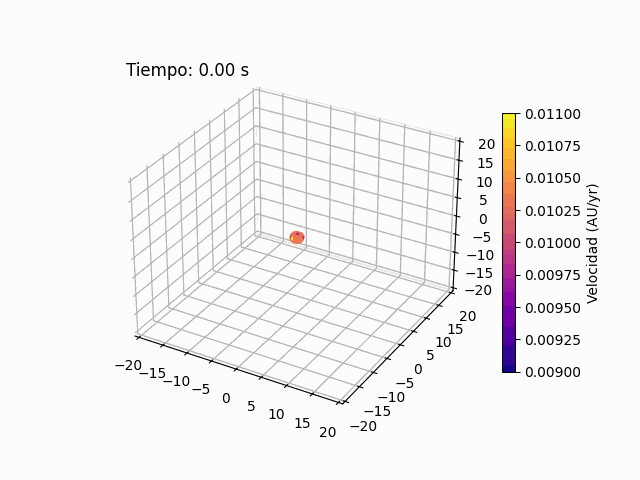

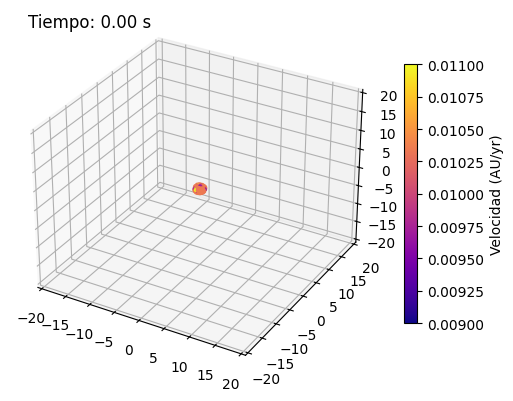

In [ ]:
# Configuración de la visualización en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Número de fotogramas y tiempo por fotograma
num_frames = positions_over_time.shape[2]
time_per_frame = 0.08  # Tiempo por fotograma en segundos

# Inicializa la variable de la barra de color
scatter = None
cbar = None

# Crear la función para actualizar cada fotograma
def update(frame):
    global scatter, cbar
    ax.clear()
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.set_zlim(-50, 50)

    # Calcular velocidades y magnitud de la velocidad
    velocities = velocities_over_time[:, :, frame]
    speed = np.linalg.norm(velocities, axis=1)

    # Escala de color basada en la velocidad
    scatter = ax.scatter(
        positions_over_time[:, 0, frame],
        positions_over_time[:, 1, frame],
        positions_over_time[:, 2, frame],
        s=5,
        c=speed,
        cmap='plasma',
    )

    # Crear la barra de color solo una vez
    if cbar is None:
        cbar = fig.colorbar(scatter, ax=ax, shrink=0.7)
        cbar.set_label("Velocidad (AU/yr)")

    # Mostrar el tiempo de simulación
    time = frame * time_per_frame
    ax.text2D(0.05, 0.95, f"Tiempo: {time:.2f} s", transform=ax.transAxes, fontsize=12, color='black')

ani = FuncAnimation(fig, update, frames=num_frames, interval=50)

# Guardar el GIF
writer = PillowWriter(fps=20)
ani.save("sph_simulation.gif", writer=writer)

# Mostrar el GIF
from IPython.display import Image
Image(open("sph_simulation.gif", 'rb').read())
